In [1]:
import pandas as pd
import sklearn 
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import Lasso
import mlflow

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'



In [2]:
import mlflow 

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops_ds/02-experiment tracking/mlruns/1', creation_time=1724432541929, experiment_id='1', last_update_time=1724432541929, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [5]:
#Q1: 19 columns 
df.shape 

(3066766, 19)

In [6]:
type(df['tpep_pickup_datetime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [7]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df['duration'].dt.total_seconds() / 60.0

In [8]:
df.duration.mean()

15.668995167330452

In [11]:
#Q2 
df.duration.std()

42.59435124195458

In [12]:
#Q3: fraction of the records left after you dropped the outliers
len(df[(df['duration']>=1) & (df['duration']<=60)]) / len(df) * 100

98.1220282212598

In [9]:
#Q4: one hot encoding 
categorical = ['PULocationID', 'DOLocationID']

df[categorical] = df[categorical].astype(str)

In [10]:
train_dict = df[categorical].to_dict(orient='records')

In [11]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [16]:
print(f'(feature matrix size: {X_train.shape}')

(feature matrix size: (3066766, 518)


In [12]:
#Q5: Train a model
target = 'duration'
y_train = df[target].values
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [23]:
y_train[:10]

array([ 8.43333333,  6.31666667, 12.75      ,  9.61666667, 10.83333333,
       12.3       , 10.45      , 22.73333333, 14.93333333, 10.9       ])

In [14]:
y_pred = lr.predict(X_train)
print(f'RMSE for the Linear Regression: {mean_squared_error(y_train, y_pred, squared=False)}')

RMSE for the Linear Regression: 41.9964977084757


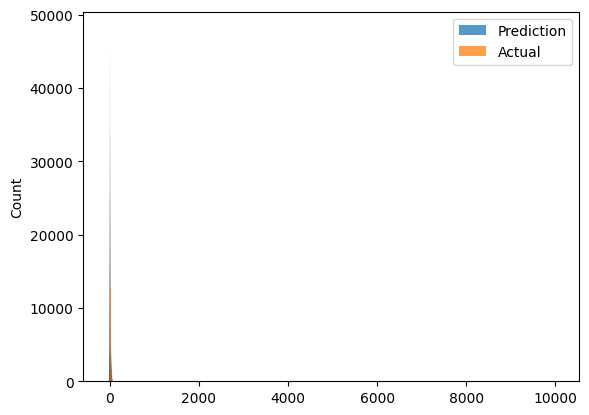

In [15]:
sns.histplot(y_pred, label='Prediction')
sns.histplot(y_train, label='Actual')
plt.legend();

In [13]:
#Q6: on validation set (feb data)
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [14]:
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')


In [15]:
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values
# y_pred = lr.predict(X_val)


In [23]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')


Val RMSE: 7.945209372021333


In [22]:
#Jan data 
df_jan = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet')
df_feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet')


In [24]:
with mlflow.start_run(): 
    mlflow.set_tag("developer", "chloe")
    mlflow.log_param("train_data", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("val_data", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [25]:
rmse

8.14867308822059

In [16]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import mlflow

In [17]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [16]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=10,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [17]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

[0]	validation-rmse:9.86141                           
[1]	validation-rmse:9.61128                           
[2]	validation-rmse:9.38523                           
[3]	validation-rmse:9.17755                           
[4]	validation-rmse:8.98781                           
[5]	validation-rmse:8.81824                           
[6]	validation-rmse:8.66485                           
[7]	validation-rmse:8.47261                           
[8]	validation-rmse:8.35218                           
[9]	validation-rmse:8.18346                           
[0]	validation-rmse:9.04197                                                    
[1]	validation-rmse:8.19793                                                    
[2]	validation-rmse:7.74171                                                    
[3]	validation-rmse:7.10975                                                    
[4]	validation-rmse:6.70501                                                    
[5]	validation-rmse:6.60129                       

: 

In [14]:
with mlflow.start_run():
    mlflow.xgboost.autolog(disable=True)
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.29594203319800283,
        'max_depth': 91,
        'min_child_weight': 4.099548466713828,
        'objective': 'reg:linear',
        'reg_alpha': 0.024620249720045145,
        'reg_lambda': 0.01824856933940444,
        'seed': 42
    }


    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=10,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    # with open("models/preprocessor.b", "wb") as f_out:
    #     pickle.dump(dv, f_out)
    # mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:8.61381
[1]	validation-rmse:7.32255
[2]	validation-rmse:6.90555
[3]	validation-rmse:6.38556
[4]	validation-rmse:6.18155
[5]	validation-rmse:6.15084
[6]	validation-rmse:6.10320
[7]	validation-rmse:6.10418
[8]	validation-rmse:6.14566
[9]	validation-rmse:6.12129


2024/08/25 22:58:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [18]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
import setuptools

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data", "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")
        mlflow.log_param("valid-data", "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")
        # mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

2024/08/25 23:08:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: Unable to allocate 11.8 GiB for an array with shape (3066766, 518) and data type float64


: 